In [5]:
!python -c "import torch.utils"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/bask/homes/g/gmmg6904/.local/lib/python3.11/site-packages/torch/utils/__init__.py", line 5, in <module>
    from .throughput_benchmark import ThroughputBenchmark
  File "/bask/homes/g/gmmg6904/.local/lib/python3.11/site-packages/torch/utils/throughput_benchmark.py", line 3, in <module>
    import torch._C
ModuleNotFoundError: No module named 'torch._C'


In [9]:
%pip install --force-reinstall torch

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.4.1-cp311-cp311-manylinux1_x86_64.whl (797.1 MB)
  Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Using cached sympy-1.13.3-py3-none-any.whl (6.2 MB)
  Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
  Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl

In [19]:
%pip install plothelp

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
import random, os

from cloudcasting.dataset import SatelliteDataset


def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.mps.manual_seed(seed)
    
seed_everything(42)

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
from diffusers import DDPMScheduler, UNet2DModel
from cloudcasting.constants import NUM_CHANNELS


class ConditionedUnet(nn.Module):
    history_steps: int
    def __init__(self, image_size, history_steps = 1):
        super().__init__()

        self.history_steps = history_steps

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (previous timesteps)
        self.model = UNet2DModel(
            sample_size=image_size,  # the target image resolution
            in_channels=NUM_CHANNELS + history_steps * NUM_CHANNELS,  # noise input + conditioning information
            out_channels=NUM_CHANNELS,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(
                128, 
                256, 
                512,
            ),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "DownBlock2D",  # a regular ResNet downsampling block
                "DownBlock2D",  # a regular ResNet downsampling block

                # "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                # "AttnDownBlock2D",
            ),
            up_block_types=(
                # "AttnUpBlock2D",
                # "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
                "UpBlock2D",  # a regular ResNet upsampling block
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
            add_attention = False,  # blows up memory with attention -- maybe do latent diffusion
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, noisy_image, conditioning, t):

        # stack noisy image and conditioning info along the time axis
        stacked = torch.cat([noisy_image, conditioning], dim=-3) 
        # print(f"{stacked.shape=}")

        # reshape to (batch, channels*time, height, width)
        net_input = stacked.reshape(-1, stacked.shape[-4] * stacked.shape[-3], *stacked.shape[-2:])

        return self.model(net_input, t).sample.reshape(noisy_image.shape)
    


In [3]:
from cloudcasting.constants import DATA_INTERVAL_SPACING_MINUTES

TRAINING_DATA_PATH = "/bask/projects/v/vjgo8416-climate/shared/data/eumetsat/training/2022_training_nonhrv.zarr"
HISTORY_STEPS = 1

# Instantiate the torch dataset object
dataset = SatelliteDataset(
    zarr_path=TRAINING_DATA_PATH,
    start_time="2022-01-31",
    end_time=None,
    history_mins=(HISTORY_STEPS - 1) * DATA_INTERVAL_SPACING_MINUTES,
    forecast_mins=15,
    sample_freq_mins=15,
    nan_to_num=True,
)

In [4]:
# Number of complete samples in the dataset
# - this includes overlapping periods, not completely distinct periods
n_samples = len(dataset)
print(n_samples)

# nan percentage
# print(f"NaN percentage: {np.mean(np.isnan(dataset.ds)).compute()}")

12291


In [5]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

batch_size = 2
num_workers = 0

train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

# train_dataloader = DataLoader(
#     dataset=dataset,
#     batch_size=batch_size,
#     num_workers=num_workers,
# )


In [6]:
dl = iter(train_dataloader)
X, y = next(dl)

assert X.shape == y.shape
while torch.mean(X) == -1:
    print('aaaaah')
    X, y = next(iter(train_dataloader))

In [7]:
# Instantiate the model
# Calculate required crop for the input dims to be divisible by 16
x_cropped_shape = [(size // 16) * 16 for size in X.shape[-2:]]
# model = ConditionedUnet(x_cropped_shape, history_steps=HISTORY_STEPS).to(device)

In [8]:
def crop(x):
    # Calculate required crop for the input dims to be divisible by 16
    x_cropped_shape = [(size // 16) * 16 for size in x.shape[-2:]]
    return x[..., :x_cropped_shape[0], :x_cropped_shape[1]]

In [16]:
####### < -- STOP -- > ##########################################################################################

In [17]:
# example sample
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
# Get some data and prepare the corrupted version
X = crop(X.to(device) * 2 - 1)  # Data on the GPU (mapped to (-1, 1)) (????)

y = crop(y.to(device) * 2 - 1)
noise = torch.randn_like(y)  # base noise on the target image
timesteps = torch.randint(0, 999, (X.shape[0],)).long().to(device)
noisy_y = noise_scheduler.add_noise(y, noise, timesteps)  # Note that we pass in the target y
# Predict the noise based on previous images and the noisy forecast target
# pred = model(noisy_y, X, timesteps).reshape(y.shape)[0]
# print(f"{pred.shape=}")

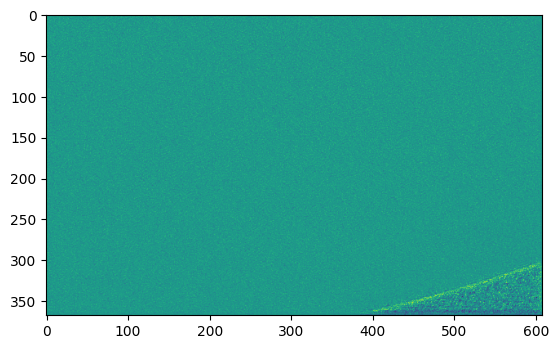

In [18]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

ax.imshow(pred[1].to("cpu").squeeze().detach().numpy())

  0%|          | 0/6146 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.171581
Finished epoch 1. Average of the last 100 loss values: 0.137424


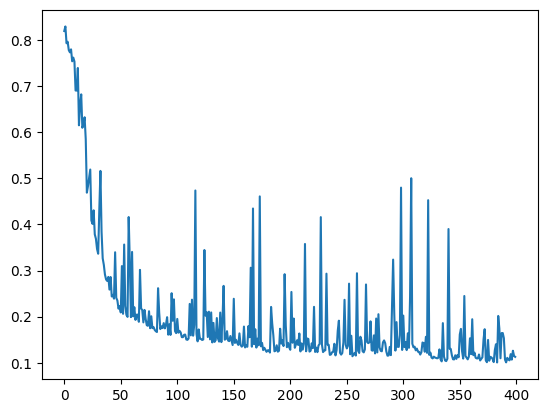

In [15]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

# How many runs through the data should we do?
n_epochs = 2

model = ConditionedUnet(x_cropped_shape, history_steps=HISTORY_STEPS).to(device)

# The optimizer
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

# Keeping a record of the losses for later viewing
losses = []
best_loss = 999
best_model = None

status_bar = tqdm(train_dataloader)

# The training loop
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(status_bar):
        
        if torch.mean(x) == -1:
            continue

        # Get some data and prepare the corrupted version
        x = crop(x.to(device))
        y = crop(y.to(device))
        
        # must be before data rescaling, after cropping
        nan_mask = (x == -1) & (y == -1)
        
        # scale data to -1, +1 [nans will go to -2]
        x, y = x * 2 - 1, y  * 2 - 1

        noise = torch.randn_like(y)  # base noise on the target image
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)  # Note that we pass in the target y

        # Predict the noise based on previous images and the noisy forecast target
        pred = model(noisy_y, x, timesteps)
        

        # Calculate the loss
        noise[nan_mask] = torch.nan
        loss = torch.nanmean(F.l1_loss(pred, noise, reduction="none"))
        
        status_bar.set_description(f"{loss=:.5g}")

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())
        # print(f"Loss: {loss.item():05f}")
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = model
            
        if (i+1) % 200 == 0:
            break

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")
    
    torch.save(best_model, f'best-model-epoch-{epoch}-loss-{best_loss:.3g}.pt')

# View the loss curve
plt.plot(losses)

In [16]:
# example sample
from tqdm.notebook import tqdm
X, y = next(dl)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
# Get some data and prepare the corrupted version
X = crop(X[1:].to(device) * 2 - 1)  # Data on the GPU (mapped to (-1, 1)) (????)
sampled_noise = torch.randn_like(crop(y[1:])).to(device)

model_0 = torch.load("best-model-epoch-1-loss-0.101.pt").to(device)
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model_0(sampled_noise, X, t)

    # Update sample with step
    sampled_noise = noise_scheduler.step(residual, t, sampled_noise).prev_sample

/tmp/ipykernel_254894/909441147.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_0 = torch.load("best-model-epoch-1-loss-0.101.pt").to(device)


0it [00:00, ?it/s]

sampled_noise.shape=torch.Size([1, 11, 1, 368, 608])
for_grid.shape=torch.Size([11, 1, 368, 608])
for_grid.shape=torch.Size([11, 1, 372, 614])


Text(0.5, 1.0, 'true')

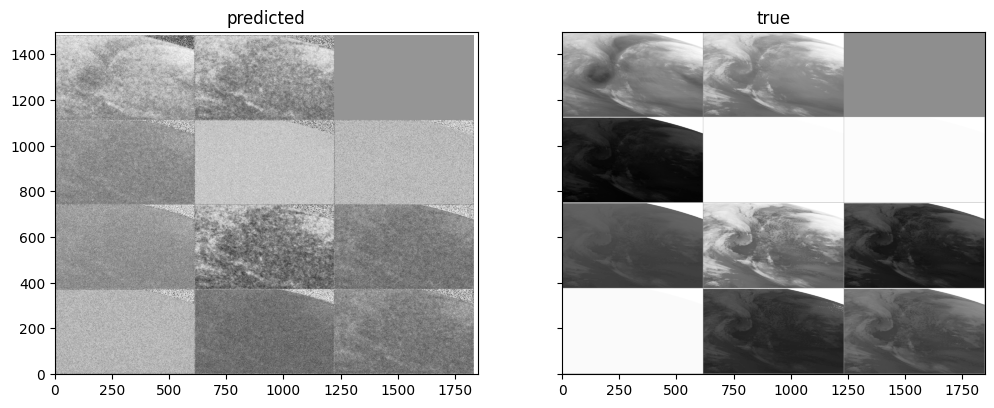

In [29]:
# Show the results

import torchvision

print(f"{sampled_noise.shape=}")

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax = axs[0]
for_grid = sampled_noise.detach().cpu().clip(-1, 1)[0]
print(f"{for_grid.shape=}")
grid = torchvision.utils.make_grid(for_grid, nrow=3)[0]
ax.imshow(grid, cmap="Greys", origin='lower')
ax.set_title("predicted")

ax = axs[1]
for_grid = (y.detach().cpu()[0] * 2 - 1).clip(-1, 1)
print(f"{for_grid.shape=}")
grid = torchvision.utils.make_grid(for_grid, nrow=3)[0]
ax.imshow(grid, cmap="Greys", origin='lower')
ax.set_title("true")


for_grid.shape=torch.Size([11, 1, 368, 608])


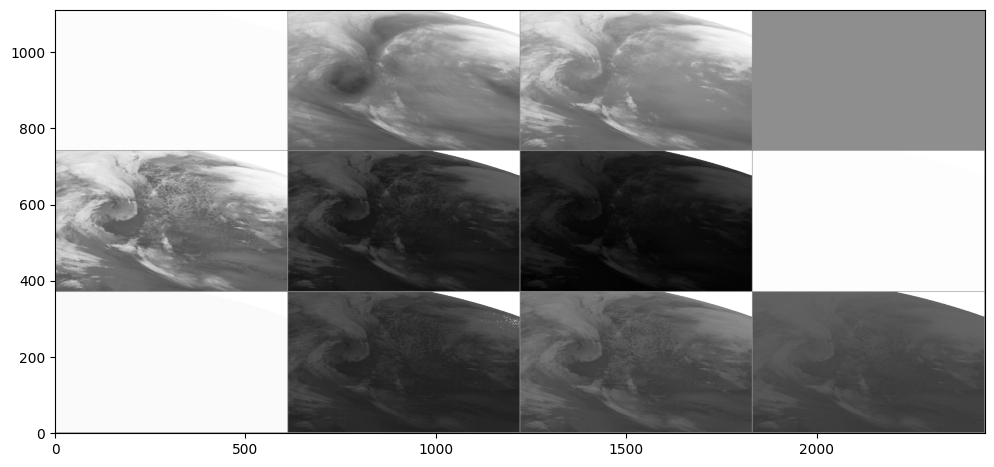

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))


In [38]:
%pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
